In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
import imblearn.over_sampling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier

all the imports

In [3]:
df = pd.read_csv('new_train.csv')
#df7test = pd.read_csv('new_test.csv')
#https://www.kaggle.com/rashmiranu/banking-dataset-classification?select=new_train.csv
#don't use test. doesn't have the same features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


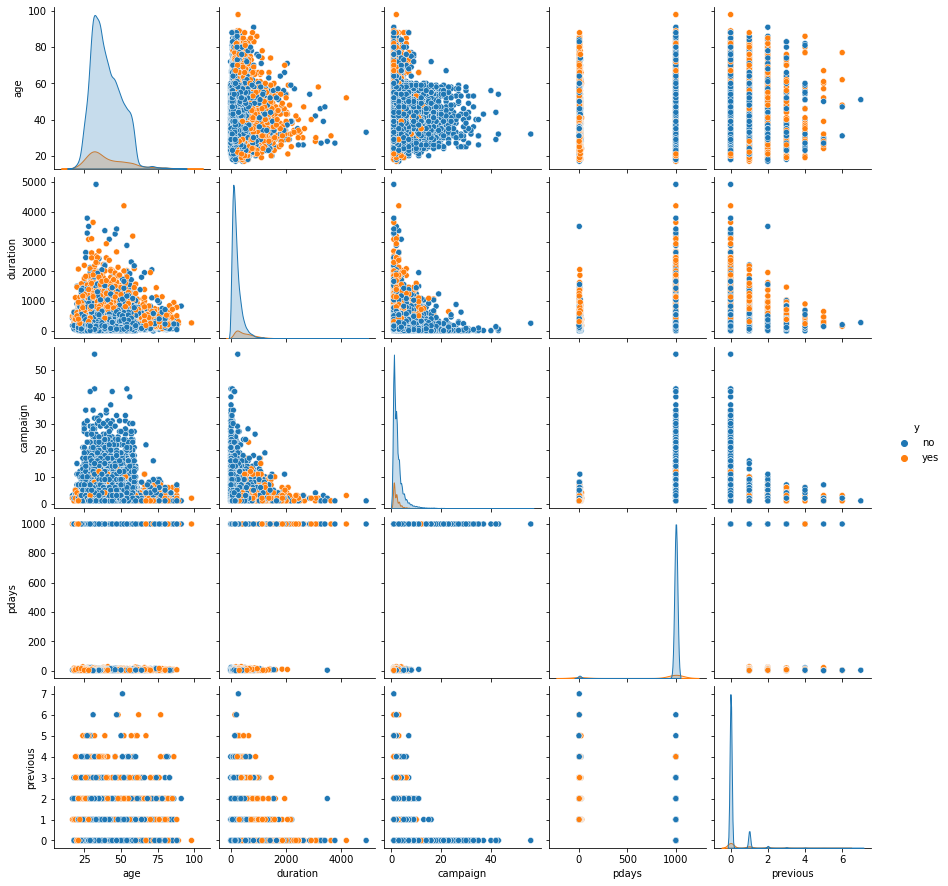

In [4]:
import seaborn as sns

sns.pairplot(df, hue='y');

We can see that there aren't any separable number variables

In [6]:
df.y.unique()

array(['no', 'yes'], dtype=object)

In [7]:
m = df.groupby(['y']).size()
print(m)

y
no     29238
yes     3712
dtype: int64


In [8]:
m = df.groupby(['pdays']).size()
print(m)
#number of days that passed by after the client was last contacted from a previous campaign 
#(999 means client was not previously contacted)

pdays
0         12
1         22
2         52
3        355
4         97
5         40
6        337
7         47
8         14
9         45
10        43
11        21
12        40
13        28
14        18
15        21
16         9
17         8
18         6
19         2
20         1
21         2
22         3
25         1
26         1
27         1
999    31724
dtype: int64


In [9]:
df.groupby(['previous']).size()
#number of contacts performed before this campaign and for this client

previous
0    28416
1     3673
2      606
3      175
4       60
5       14
6        5
7        1
dtype: int64

Not the same number people who weren't contacted (previous == 0 and pdays == 999)

In [10]:
df.groupby(['poutcome']).size()
#outcome of the previous marketing campaign ('failure','nonexistent','success')

poutcome
failure         3429
nonexistent    28416
success         1105
dtype: int64

However, there are the same number of no previous contact and nonexistent (previous == 0; poutcome == nonexistent)

In [11]:
df.groupby(['housing']).size()
#housing loan

housing
no         14900
unknown      796
yes        17254
dtype: int64

In [12]:
df.groupby(['loan']).size()
#personal loan

loan
no         27131
unknown      796
yes         5023
dtype: int64

Same number of housing and loan that we don't know exist. Check to see if same people in a bit

In [13]:
df.groupby(['default']).size()

default
no         26007
unknown     6940
yes            3
dtype: int64

Keep everyone

In [14]:
#check if unknown personal and home loan are same people
x = 0
for i in range(len(df)):
    if df.iloc[i,5] =='unknown' and df.iloc[i,6] == 'unknown':
        x +=1
print(x)

796


delete these. they're all people who we don't know if they have a loan of any kind

In [15]:
dff = df
dff = dff[dff['housing']!='unknown'] 
len(dff) # count to make sure dropped them all



32154

In [16]:
df.groupby(['y']).size()

y
no     29238
yes     3712
dtype: int64

In [17]:
29238/32154 #number of people who didn't purchase a previous product

0.9093114387012502

But remember a lot of those people weren't contacted

Let's start EDA!

In [75]:
df1 = dff

np.shape(dff)

(32154, 16)

Let's graph those non-numeric variables!!

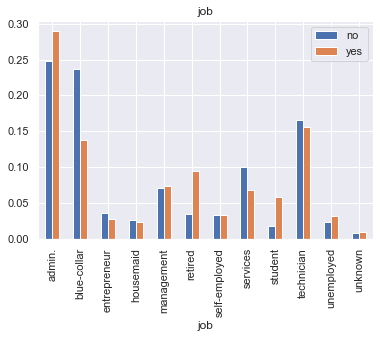

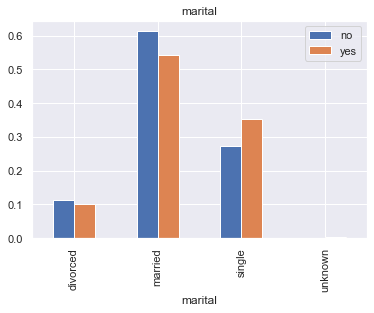

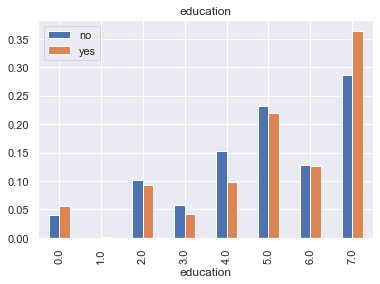

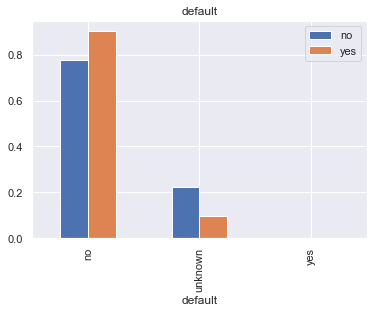

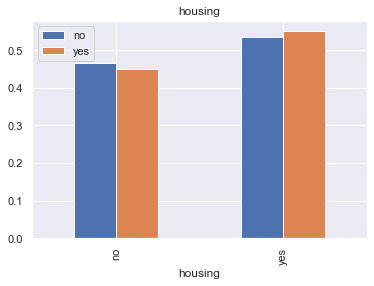

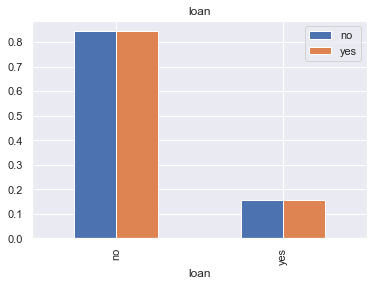

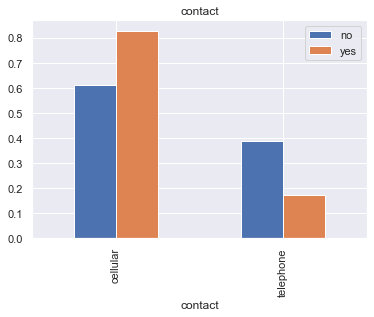

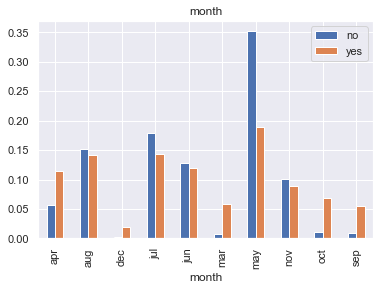

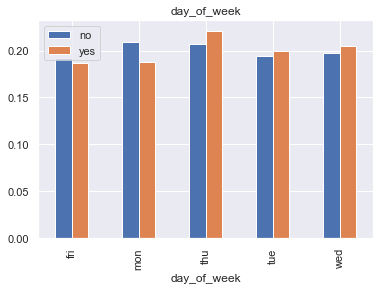

In [77]:
# under marital, divorced includes widowed 
li_of_col = ['job','marital','education','default','housing','loan','contact','month','day_of_week']
for i in range(len(li_of_col)):
    edu = dff.groupby([li_of_col[i],'y']).size().unstack(level=1)
    

    edu2 = pd.DataFrame(edu.iloc[:,0]/edu.iloc[:,0].sum())
    edu2['yes'] =(edu.iloc[:,1]/edu.iloc[:,1].sum())

    edu2.plot.bar()
    plt.title(li_of_col[i])


In [20]:
df1.education.unique()

array(['basic.9y', 'university.degree', 'basic.4y', 'high.school',
       'professional.course', 'unknown', 'basic.6y', 'illiterate'],
      dtype=object)

In [21]:
ed_list = [['unknown','illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']]

In [22]:
enc = OrdinalEncoder(categories = ed_list)
dff2 = df1
enc.fit(dff2[['education']])
dff2[['education']] = enc.transform(dff2[['education']])


/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [23]:
dff2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,4.0,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,7.0,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,2.0,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,7.0,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,7.0,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


Great! We've converted education into an ordinal variable. Let's do one more pairplot and then convert some more categorical variables

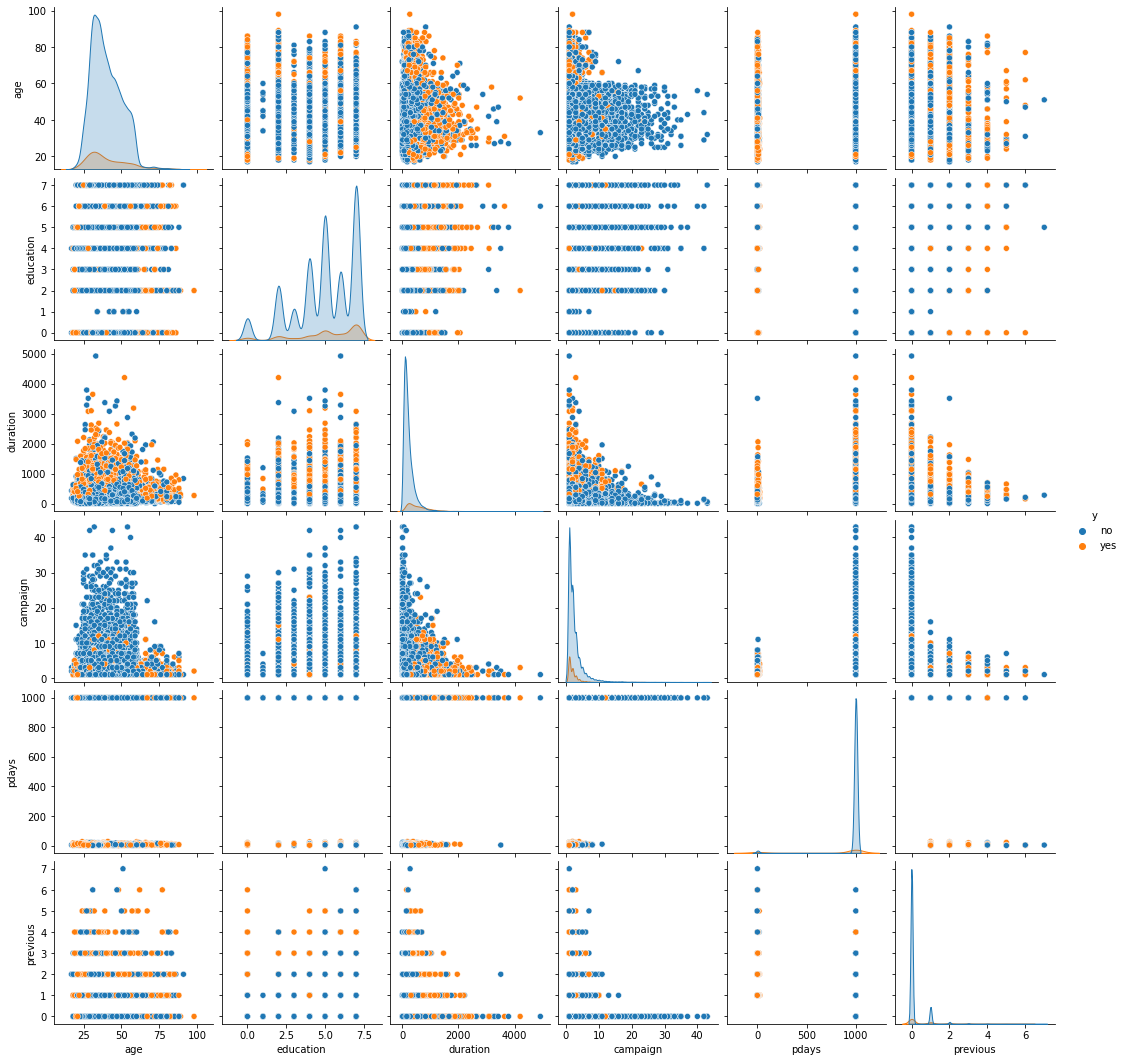

In [24]:
sns.pairplot(dff2, hue='y');

Still nothing separable. On to categorical conversion!

In [25]:
df2 = pd.get_dummies(dff2, columns = ['job'])
#df2.info()


In [26]:
df3 = pd.get_dummies(df2, columns = ['marital'])
#df3.info()


In [27]:
df3.head()

,age,education,default,housing,loan,contact,month,day_of_week,duration,campaign,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown
0,49,4.0,unknown,no,no,cellular,nov,wed,227,4,...,0,0,0,0,0,0,0,1,0,0
1,37,7.0,no,no,no,telephone,nov,wed,202,2,...,0,0,0,0,0,0,0,1,0,0
2,78,2.0,no,no,no,cellular,jul,mon,1148,1,...,0,0,0,0,0,0,0,1,0,0
3,36,7.0,no,yes,no,telephone,may,mon,120,2,...,0,0,0,0,0,0,0,1,0,0
4,59,7.0,no,no,no,cellular,jun,tue,368,2,...,0,0,0,0,0,0,1,0,0,0


In [28]:
df5 = pd.get_dummies(df3, columns = ['default','housing','loan','poutcome','y'])
#df5.info()

In [29]:
df5.drop(['job_unknown','marital_unknown','default_unknown','housing_no','loan_no','poutcome_nonexistent','y_no'],axis = 1,inplace = True)
#df5.info()

In [30]:
df5.drop(['contact','month','day_of_week'],axis = 1,inplace = True)
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32154 entries, 0 to 32949
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                32154 non-null  int64  
 1   education          32154 non-null  float64
 2   duration           32154 non-null  int64  
 3   campaign           32154 non-null  int64  
 4   pdays              32154 non-null  int64  
 5   previous           32154 non-null  int64  
 6   job_admin.         32154 non-null  uint8  
 7   job_blue-collar    32154 non-null  uint8  
 8   job_entrepreneur   32154 non-null  uint8  
 9   job_housemaid      32154 non-null  uint8  
 10  job_management     32154 non-null  uint8  
 11  job_retired        32154 non-null  uint8  
 12  job_self-employed  32154 non-null  uint8  
 13  job_services       32154 non-null  uint8  
 14  job_student        32154 non-null  uint8  
 15  job_technician     32154 non-null  uint8  
 16  job_unemployed     321

In [31]:
y = df5['y_yes']

In [32]:
X = df5
X.drop(['y_yes'],axis = 1,inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32154 entries, 0 to 32949
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                32154 non-null  int64  
 1   education          32154 non-null  float64
 2   duration           32154 non-null  int64  
 3   campaign           32154 non-null  int64  
 4   pdays              32154 non-null  int64  
 5   previous           32154 non-null  int64  
 6   job_admin.         32154 non-null  uint8  
 7   job_blue-collar    32154 non-null  uint8  
 8   job_entrepreneur   32154 non-null  uint8  
 9   job_housemaid      32154 non-null  uint8  
 10  job_management     32154 non-null  uint8  
 11  job_retired        32154 non-null  uint8  
 12  job_self-employed  32154 non-null  uint8  
 13  job_services       32154 non-null  uint8  
 14  job_student        32154 non-null  uint8  
 15  job_technician     32154 non-null  uint8  
 16  job_unemployed     321

In [33]:
X_tr,X_test,y_tr,y_test = train_test_split(X,y,test_size= .2,random_state =42, stratify=y)
#
print(np.shape(X_tr))
print(np.shape(y_tr))

(25723, 26)
(25723,)


In [34]:
X_train,X_val,y_train,y_val = train_test_split(X_tr,y_tr, test_size = .25, random_state = 42, stratify = y_tr)

In [35]:
X_train['total_product'] = X_train['housing_yes'] + X_train['loan_yes']
#X_train.info()

/var/folders/cp/7qmpmnt105b1wpvjj8wd7r140000gp/T/ipykernel_28609/681412576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_product'] = X_train['housing_yes'] + X_train['loan_yes']


In [36]:
#VERY basic logistic regression
lm1 = LogisticRegression(C=1) # setting C at one to equalize regularization
x_tr_tot_prod = np.array(X_train['total_product'])
x_tr_tot_prod = x_tr_tot_prod.reshape(-1,1)
lm1.fit(x_tr_tot_prod, y_train)
lm1.score(x_tr_tot_prod, y_train)


0.8873626373626373

just number of purchases = 0.9093114387012502. so not good.

In [37]:

X_val['total_product'] = X_val['housing_yes'] + X_val['loan_yes']
x_te_tot_prod = np.array(X_val['total_product'])
x_te_tot_prod = x_te_tot_prod.reshape(-1,1)
y_pred = lm1.predict(x_te_tot_prod)
metrics.confusion_matrix(y_val, y_pred)


/var/folders/cp/7qmpmnt105b1wpvjj8wd7r140000gp/T/ipykernel_28609/242850120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['total_product'] = X_val['housing_yes'] + X_val['loan_yes']


array([[5706,    0],
       [ 725,    0]])

ah. no good at all

In [38]:
#VERY basic random forest
rf1 = RandomForestClassifier() # setting C at one to equalize regularization
x_tr_tot_prod = np.array(X_train['total_product'])
x_tr_tot_prod = x_tr_tot_prod.reshape(-1,1)
rf1.fit(x_tr_tot_prod, y_train)
rf1.score(x_tr_tot_prod, y_train)

y_pred2 = rf1.predict(x_te_tot_prod)
metrics.confusion_matrix(y_val, y_pred2)

array([[5706,    0],
       [ 725,    0]])

Let's try linear regression on the whole data set

In [39]:
lm1.fit(X_train,y_train)
print(lm1.score(X_train, y_train))

#not a very good improvement

0.9038461538461539


/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
y_pred = lm1.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))
print(recall_score(y_val,lm1.predict(X_val)))

[[5582  124]
 [ 482  243]]
0.3351724137931035


Not enough false positives, too many false negatives

In [41]:
lm1.fit(X_train[['poutcome_failure','poutcome_success']], y_train)
lm1.score(X_train[['poutcome_failure','poutcome_success']], y_train)

0.8974186191167324

In [42]:
y_pred = lm1.predict(X_val[['poutcome_failure','poutcome_success']])
print(metrics.confusion_matrix(y_val, y_pred))
print(recall_score(y_val,lm1.predict(X_val[['poutcome_failure','poutcome_success']])))

[[5633   73]
 [ 581  144]]
0.1986206896551724


This is good. We don't want the poutcome variable set to be a good predictor because so few people were contacted in the first place.

In [43]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

lr = LogisticRegression(solver='liblinear') 
lr.fit(X_train, y_train)

print('Simple Logistic Regression; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr.predict(X_val)), roc_auc_score(y_val, lr.predict_proba(X_val)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_os.predict(X_val)), roc_auc_score(y_val, lr_os.predict_proba(X_val)[:,1])))
y_pred = lr_os.predict(X_val)
print(metrics.confusion_matrix(y_val,y_pred))

Simple Logistic Regression; Test recall: 0.341, Test AUC: 0.893
Logistic Regression on Oversampled Train Data; Test recall: 0.669, Test AUC: 0.895
[[5142  564]
 [ 240  485]]


 better recall 

In [95]:

probs = lr.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

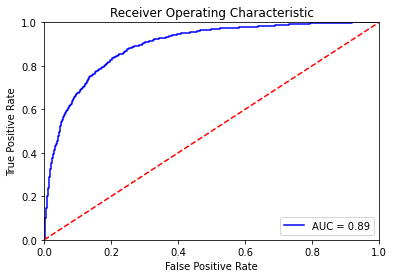

In [96]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_smote.predict(X_val)), roc_auc_score(y_val, lr_smote.predict_proba(X_val)[:,1])))
y_pred = lr_smote.predict(X_val)
print(metrics.confusion_matrix(y_val,y_pred))

Logistic Regression on SMOTE Train Data; Test recall: 0.434, Test AUC: 0.876
[[5470  236]
 [ 410  315]]


SMOTE doesn't have good enough recall, and false negatives are too high

In [51]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train[['duration','campaign','pdays','previous']], y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_smote.predict(X_val[['duration','campaign','pdays','previous']])), roc_auc_score(y_val, lr_smote.predict_proba(X_val[['duration','campaign','pdays','previous']])[:,1])))

y_pred = lr_smote.predict(X_val[['duration','campaign','pdays','previous']])
print(metrics.confusion_matrix(y_val, y_pred))

Logistic Regression on SMOTE Train Data; Test recall: 0.643, Test AUC: 0.862
[[5208  498]
 [ 259  466]]


This is better SMOTE data than the entire data set, but we really don't want to use just campaign information, given so few people were targeted. Let's see if we can do as well with the entire data set and some other categorizer

In [53]:
dectree = DecisionTreeClassifier(max_depth=4)
dectree.fit(X_train,y_train)
print('Decision Tree; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, dectree.predict(X_val)), roc_auc_score(y_val, dectree.predict_proba(X_val)[:,1]))) 

y_pred = dectree.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Decision Tree; Test recall: 0.383, Test AUC: 0.857
[[5570  136]
 [ 447  278]]


Decision tree works remarkably poorly. 

In [54]:
dectree = DecisionTreeClassifier(max_depth=10)
dectree.fit(X_train,y_train)
print('Decision Tree; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, dectree.predict(X_val)), roc_auc_score(y_val, dectree.predict_proba(X_val)[:,1]))) 

y_pred = dectree.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Decision Tree; Test recall: 0.412, Test AUC: 0.842
[[5509  197]
 [ 426  299]]


In [55]:
dectree = DecisionTreeClassifier(max_depth=20)
dectree.fit(X_train,y_train)
print('Decision Tree; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, dectree.predict(X_val)), roc_auc_score(y_val, dectree.predict_proba(X_val)[:,1]))) 

y_pred = dectree.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Decision Tree; Test recall: 0.401, Test AUC: 0.677
[[5297  409]
 [ 434  291]]


Our false negative is going up. This isn't a good direction to go.

let's try some cross-validation!!

In [44]:

 

# define pipeline
steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
#steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]

pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
scores = cross_val_score(pipeline, X_tr, y_tr, scoring='recall', cv=cv, n_jobs=-1)
score = np.mean(scores)
sc_var = np.var(scores)
print('Recall Score: %.3f' % score)
print('variance: %.6f' % sc_var)
    


Recall Score: 0.751
variance: 0.000665


In [45]:
# define pipeline
#steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]

pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
scores = cross_val_score(pipeline, X_tr, y_tr, scoring='recall', cv=cv, n_jobs=-1)
score = np.mean(scores)
sc_var = np.var(scores)
print('Recall Score: %.3f' % score)
print('variance: %.6f' % sc_var)





Recall Score: 0.387
variance: 0.000820


We forgot random forests!!!!

In [46]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)
print('RandomForest; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, rf.predict(X_val)), roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))) 

y_pred = rf.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

RandomForest; Test recall: 0.360, Test AUC: 0.874
[[5553  153]
 [ 464  261]]


Random forest isn't doing much better - false negative rate is still too high and recall is very poor

In [47]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train,y_train)
print('RandomForest; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, rf.predict(X_val)), roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))) 

y_pred = rf.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

RandomForest; Test recall: 0.364, Test AUC: 0.879
[[5556  150]
 [ 461  264]]


let's change the threshold

Logistic Regression Model best F1 score 0.554 at prob decision threshold >= 0.274


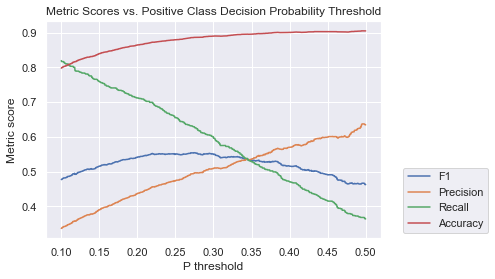

In [48]:
sns.set()


thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = rf.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Let's try 0.27 (max F1)

In [49]:
#Try random forest without product variables
nonProd_list = ['age','education','job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_self-employed','job_services','job_student','job_technician','job_unemployed','marital_divorced','marital_married','marital_single','default_no','default_yes','housing_yes','loan_yes']
rf.fit(X_train[nonProd_list],y_train)
print('RandomForest; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, rf.predict(X_val[nonProd_list])), roc_auc_score(y_val, rf.predict_proba(X_val[nonProd_list])[:,1]))) 

y_pred = rf.predict(X_val[nonProd_list])
print(metrics.confusion_matrix(y_val, y_pred))
#leave them in

RandomForest; Test recall: 0.091, Test AUC: 0.597
[[5493  213]
 [ 659   66]]


In [51]:
#https://www.geeksforgeeks.org/decision-threshold-in-machine-learning/
#df = clf.decision_function(x_test)
sdf = rf.predict_proba(X_val[nonProd_list])

# Set the value of decision threshold.
decision_threshold = 0.27

# Desired prediction to increase precision value.
desired_predict =[]

# Iterate through each value of decision function output
# and if decision score is > than Decision threshold then,
# append (1) to the empty list ( desired_prediction) else
# append (0).
for i in sdf:
    if i[0]<decision_threshold:
        desired_predict.append(0)
    else:
        desired_predict.append(1)

In [52]:
# Comparison

# Old Precision Value
print("old recall score:", recall_score(y_val, rf.predict(X_val[nonProd_list])))
# New precision Value
print("new recall value:", recall_score(y_val, desired_predict))
print(metrics.confusion_matrix(y_val, desired_predict))

old recall score: 0.0910344827586207
new recall value: 0.9627586206896551
[[  37 5669]
 [  27  698]]


/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Well that's a much better recall value. The false positive value is a little overwhelming, but remember we didn't contact that many people to begin with.

In [53]:
bbc = BalancedBaggingClassifier(n_estimators = 100, sampling_strategy = .5)
bbc.fit(X_train,y_train)

BalancedBaggingClassifier(n_estimators=100, sampling_strategy=0.5)

In [54]:
print('Bagging Classifier; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, bbc.predict(X_val)), roc_auc_score(y_val,bbc.predict_proba(X_val)[:,1]))) 

y_pred = bbc.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Bagging Classifier; Test recall: 0.646, Test AUC: 0.892
[[5244  462]
 [ 257  468]]


this isn't getting better than the random forest with a different threshold

In [55]:
#https://www.geeksforgeeks.org/decision-threshold-in-machine-learning/
#df = clf.decision_function(x_test)
sdf = bbc.predict_proba(X_val)

# Set the value of decision threshold.
decision_threshold = 0.1

# Desired prediction to increase precision value.
desired_predict =[]

# Iterate through each value of decision function output
# and if decision score is > than Decision threshold then,
# append (1) to the empty list ( desired_prediction) else
# append (0).
for i in sdf:
    if i[0]<decision_threshold:
        desired_predict.append(0)
    else:
        desired_predict.append(1)

In [56]:
# Comparison

# Old Precision Value
print("old recall score:", recall_score(y_val, bbc.predict(X_val)))
# New precision Value
print("new recall value:", recall_score(y_val, desired_predict))
print(metrics.confusion_matrix(y_val, desired_predict))


old recall score: 0.6455172413793103
new recall value: 0.9117241379310345
[[  24 5682]
 [  64  661]]


This is a better recall value, and false negative rate is lower. 

In [57]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
scores = cross_val_score(bbc, X_tr, y_tr, scoring='recall', cv=cv, n_jobs=-1)
score = np.mean(scores)
sc_var = np.var(scores)
print('Recall Score: %.3f' % score)
print('variance: %.6f' % sc_var)


Recall Score: 0.644
variance: 0.000736


In [58]:
#https://datascience.stackexchange.com/questions/25987/how-to-print-feature-names-in-conjunction-with-feature-importance-using-imbalanc
ln = X_train.shape
names = ["x%s" % i for i in range(1, ln[1] + 1)]
names = np.array(names)
for x, feat_sel in zip(bbc.estimators_, bbc.estimators_features_):
    feat_imp =  np.nonzero(x.named_steps['classifier'].feature_importances_)
    #print(names[feat_sel[feat_imp]])


set up categorizer without marketing features

find maximum F1 score

use that to determine cut off point 

In [59]:
nonProd_list = ['age','education','job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_self-employed','job_services','job_student','job_technician','job_unemployed','marital_divorced','marital_married','marital_single','default_no','default_yes','housing_yes','loan_yes']
rf.fit(X_train[nonProd_list],y_train)
print('RandomForest; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, rf.predict(X_val[nonProd_list])), roc_auc_score(y_val, rf.predict_proba(X_val[nonProd_list])[:,1]))) 

y_pred = rf.predict(X_val[nonProd_list])
print(metrics.confusion_matrix(y_val, y_pred))


RandomForest; Test recall: 0.091, Test AUC: 0.597
[[5493  213]
 [ 659   66]]


Logistic Regression Model best F1 score 0.244 at prob decision threshold >= 0.172


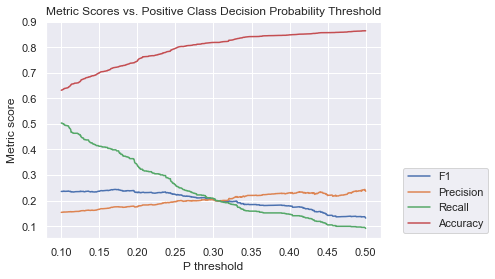

In [60]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = rf.predict_proba(X_val[nonProd_list])[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [61]:
#https://www.geeksforgeeks.org/decision-threshold-in-machine-learning/
#df = clf.decision_function(x_test)
sdf = rf.predict_proba(X_val[nonProd_list])

# Set the value of decision threshold.
decision_threshold = 0.172

# Desired prediction to increase precision value.
desired_predict =[]

# Iterate through each value of decision function output
# and if decision score is > than Decision threshold then,
# append (1) to the empty list ( desired_prediction) else
# append (0).
for i in sdf:
    if i[0]<decision_threshold:
        desired_predict.append(0)
    else:
        desired_predict.append(1)

In [62]:
# Comparison

# Old Precision Value
print("old recall score:", recall_score(y_val, rf.predict(X_val[nonProd_list])))
# New precision Value
print("new recall value:", recall_score(y_val, desired_predict))
print(metrics.confusion_matrix(y_val, desired_predict))



old recall score: 0.0910344827586207
new recall value: 0.9820689655172414
[[  19 5687]
 [  13  712]]


This is better than random forest with all features: the false negative is lower than the true negative

In [63]:
y_pred = rf.predict(X_test[nonProd_list])
print(metrics.confusion_matrix(y_test, y_pred))

[[5514  193]
 [ 651   73]]


In [64]:
#https://www.geeksforgeeks.org/decision-threshold-in-machine-learning/
#df = clf.decision_function(x_test)
sdf = rf.predict_proba(X_test[nonProd_list])

# Set the value of decision threshold.
decision_threshold = 0.172

# Desired prediction to increase precision value.
desired_predict =[]

# Iterate through each value of decision function output
# and if decision score is > than Decision threshold then,
# append (1) to the empty list ( desired_prediction) else
# append (0).
for i in sdf:
    if i[0]<decision_threshold:
        desired_predict.append(0)
    else:
        desired_predict.append(1)

        
# Comparison

# Old Precision Value
print("old recall score:", recall_score(y_test, rf.predict(X_test[nonProd_list])))
# New precision Value
print("new recall value:", recall_score(y_test, desired_predict))
print(metrics.confusion_matrix(y_val, desired_predict))
        

old recall score: 0.10082872928176796
new recall value: 0.9820441988950276
[[  26 5680]
 [   4  721]]


In [188]:
#https://vitalflux.com/feature-importance-random-forest-classifier-python/
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

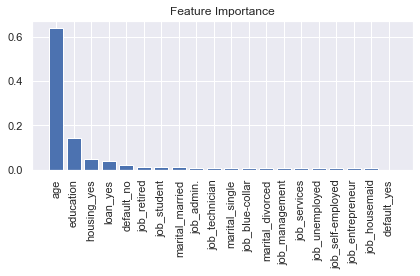

In [189]:
#https://vitalflux.com/feature-importance-random-forest-classifier-python/
plt.title('Feature Importance')
plt.bar(range(X_val[nonProd_list].shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_val[nonProd_list].shape[1]), X_val[nonProd_list].columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

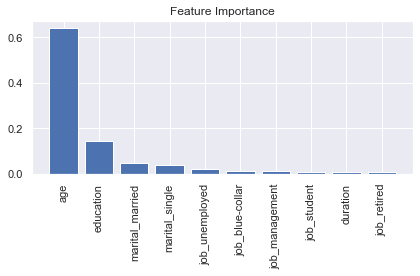

In [190]:
#https://vitalflux.com/feature-importance-random-forest-classifier-python/
plt.title('Feature Importance')
plt.bar(range(10), importances[sorted_indices][0:10], align='center')
plt.xticks(range(10), X_val[nonProd_list].columns[sorted_indices][0:10], rotation=90)
plt.xticks(range(10), X_val.columns[sorted_indices][0:10], rotation=90)
plt.tight_layout()
plt.show()

In [192]:
X_val[nonProd_list].columns[sorted_indices][0:10]

Index(['age', 'education', 'housing_yes', 'loan_yes', 'default_no',
       'job_retired', 'job_student', 'marital_married', 'job_admin.',
       'job_technician'],
      dtype='object')

In [159]:
rf.fit(X_train,y_train)
print('RandomForest; Test recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, rf.predict(X_val)), roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))) 

y_pred = rf.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

RandomForest; Test recall: 0.360, Test AUC: 0.874
[[5553  153]
 [ 464  261]]


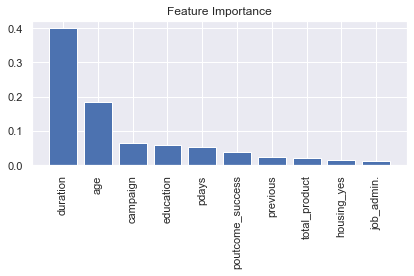

In [175]:
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]


plt.title('Feature Importance')
#plt.bar(range(X_val.shape[1]), importances[sorted_indices][0:10], align='center')
plt.bar(range(10), importances[sorted_indices][0:10], align='center')
#plt.xticks(range(X_val.shape[1]), X_val.columns[sorted_indices], rotation=90)
plt.xticks(range(10), X_val.columns[sorted_indices][0:10], rotation=90)
plt.tight_layout()
plt.show()

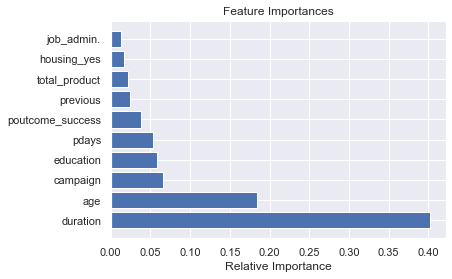

In [178]:
#https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
plt.title('Feature Importances')
plt.barh(range(10), importances[sorted_indices][0:10], color='b', align='center')
plt.yticks(range(10), [X_val.columns[i] for i in sorted_indices[0:10]])
plt.xlabel('Relative Importance')
plt.show()